In [28]:
from finance_utils.electrical.china.spot.discrete.probabilistic_forecast import DiscreteSpot,ProbabilisticDiscreteCurve
from finance_utils.electrical.china.spot.discrete.testback import TestBack
from finance_utils.electrical.china.spot.rule.recycle import SampleRecycle
import numpy

In [29]:
from data_utils.stochastic_utils.distributions.baseclass import ABCDistribution
from data_utils.stochastic_utils.distributions.basic_distributions import NormalDistribution

In [30]:
quantity_min = 0
quantity_max = 30

dayahead = ProbabilisticDiscreteCurve([
    NormalDistribution(200, 9),
    NormalDistribution(201, 8),
    NormalDistribution(203, 7),
    NormalDistribution(102, 6),
])

realtime = ProbabilisticDiscreteCurve([
    NormalDistribution(200 * 1.5, 20),
    NormalDistribution(201 * 1.1, 21),
    NormalDistribution(203 * 1.2, 22),
    NormalDistribution(102 * 0.5, 53),
])

quantity = ProbabilisticDiscreteCurve([
    NormalDistribution(10, 5),
    NormalDistribution(9, 3),
    NormalDistribution(15, 1),
    NormalDistribution(25, 2),
], domain_min=quantity_min, domain_max=quantity_max)

spot = DiscreteSpot(dayahead, realtime, quantity)

In [31]:
from matplotlib import pyplot

In [32]:
trigger_rate = 0.09
punishment_rate = 0.5

In [33]:
testback = TestBack(spot.diff_random_sample(p=0.2, n=50, epoch=50, use_random=True))
submitt_control = spot.quantity.value_list

In [34]:
submitt_test = testback.continuous_random_grid_search(
    spot.quantity.value_list, delta_min=-20, delta_max=20, epoch=20, rounds=20, submitted_min=0, 
    submitted_max=30, recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate)[-1][0]
submitt_test2 = testback.random_grid_search(
    submitted_list= spot.quantity.value_list, 
    delta_min=-20, 
    delta_max=20, 
    epoch=400, 
    submitted_min=0, 
    submitted_max=30, 
    recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate
)[0]
submitt_test3 = testback.differential_evolution__search(
    spot.quantity.value_list,
    delta_min=-20, 
    delta_max=20,
    submitted_min=0, 
    submitted_max=30,
    recycle=SampleRecycle, 
    trigger_rate=trigger_rate,  
    punishment_rate=punishment_rate
)
submitt_test4 = spot.differential_evolution__search(
    spot.quantity.value_list,
    delta_min=-20, 
    delta_max=20,
    submitted_min=0, 
    submitted_max=30,
    recycle=SampleRecycle, 
    trigger_rate=trigger_rate,  
    punishment_rate=punishment_rate
)
print(spot.quantity.value_list)
print([submitt_test3[0].tolist(), submitt_test3[1]])
print([submitt_test4[0].tolist(), submitt_test4[1]])
print(submitt_test)
print(submitt_test2)

[10, 9, 15, 25]
[[0.059286745441248456, 28.851558861208872, 1.5437699249671226, 29.95863764983601], 9233.134133252242]
[[0.05800957684506791, 23.605773716974095, 0.4761811233721627, 29.818172006176965], 10940.01680931043]
[0, 1.5969796563028957, 28.8569862119389, 30.0]
[0, 27.325892691589587, 0.8270178371153527, 30]


In [35]:
noise_dayahead = ProbabilisticDiscreteCurve([
    NormalDistribution(200, 9 * 1.5),
    NormalDistribution(201, 8 * 1.5),
    NormalDistribution(203, 7 * 1.5),
    NormalDistribution(102, 6 * 1.5),
])

noise_realtime = ProbabilisticDiscreteCurve([
    NormalDistribution(200 * 1.2, 20 * 1.5),
    NormalDistribution(201 * 1.1, 21 * 1.5),
    NormalDistribution(203 * 1.2, 22 * 1.5),
    NormalDistribution(102 * 0.8, 53 * 1.5),
])

noise_quantity = ProbabilisticDiscreteCurve([
    NormalDistribution(10, 5 * 1.5),
    NormalDistribution(9, 3 * 1.5),
    NormalDistribution(15, 1 * 1.5),
    NormalDistribution(25, 2 * 1.5),
], domain_min=quantity_min, domain_max=quantity_max)
noise_spot = DiscreteSpot(dayahead, realtime, quantity)

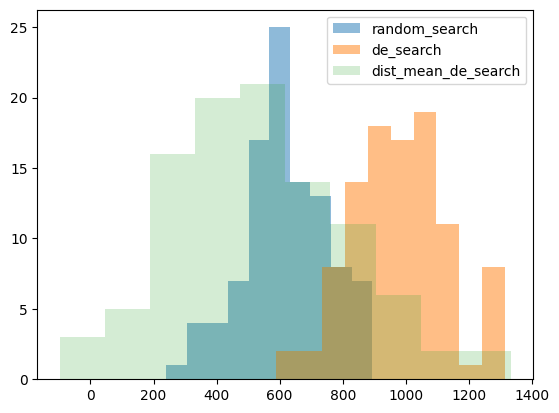

In [44]:
rec = []
for _ in range(100):
    # temp_testback = TestBack(noise_spot.random_sample(n=50, epoch=50, use_random=True))
    temp_testback = TestBack(noise_spot.diff_random_sample(p=0.6, n=100, epoch=100, use_random=True))
    temp_control_yield = temp_testback.testback_yield(submitt_control, recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).mean()
    temp_random_search_yield = temp_testback.testback_yield(submitt_test, recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).mean()
    temp_de_search_yield = temp_testback.testback_yield(submitt_test3[0], recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).mean()
    temp_de_search_yield2 = temp_testback.testback_yield(submitt_test4[0], recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).mean()
    rec.append([temp_random_search_yield - temp_control_yield, temp_de_search_yield-temp_control_yield, temp_de_search_yield2 - temp_control_yield])
    rec_array = numpy.array(rec)
pyplot.hist(rec_array[:,0], alpha=0.5)
pyplot.hist(rec_array[:,1], alpha=0.5)
pyplot.hist(rec_array[:,2], alpha=0.2)
pyplot.legend(["random_search", "de_search", "dist_mean_de_search"])
pyplot.show()

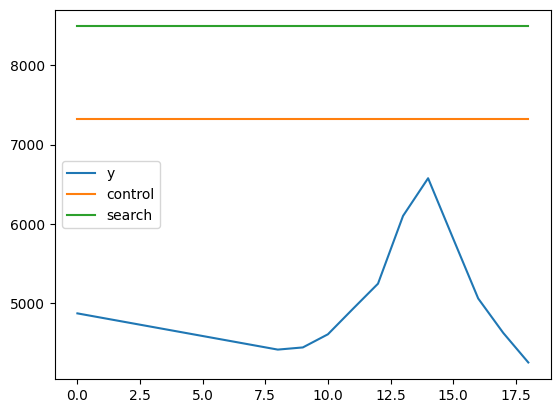

In [37]:
y_hat = [
    numpy.mean(
        temp_testback.testback_yield([i] * 4, recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).yield_curve
    ) for i in range(1,20)
]
y_control = [
    numpy.mean(
        temp_testback.testback_yield(spot.quantity.value_list, recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).yield_curve
    ) for i in range(1,20)
]
y_search = [
    numpy.mean(
        temp_testback.testback_yield(
            submitt_test3[0],recycle=SampleRecycle, trigger_rate=trigger_rate, punishment_rate=punishment_rate).yield_curve
    ) for i in range(1,20)
]
# pyplot.plot(y)
pyplot.plot(y_hat)
pyplot.plot(y_control)
pyplot.plot(y_search)
pyplot.legend(["y","control","search"])
pyplot.show()

In [38]:
print(noise_quantity.diff_random_sample(n=100, epoch=100).tolist())

[[14.14846279159215, 1.5983404349601136, 16.191798858779293, 29.11831094848671], [6.110839362301077, 9.15345474973596, 12.631377311232672, 22.127779060697545], [10.212785095072054, 8.505562984276217, 13.521931401937408, 24.388841108743073], [5.406527311677869, 5.4101432776475535, 14.411021513730269, 26.36344350369604], [1.8602726447372735, 15.013449368514229, 14.443498939087618, 25.713396219710212], [6.549006926568488, 13.85232562372762, 19.884455827217394, 30.0], [6.132139547380694, 13.279167150588961, 16.798524518397628, 29.491072188230397], [19.570190169809333, 22.549238896672964, 13.224964042217016, 26.31632372124094], [0.0, 7.80167435770929, 12.588321958278547, 21.577681759864124], [0.6927247208776137, 0.6275699144939758, 5.054292681376678, 28.143517216475345], [4.896143434878763, 5.710391940374118, 15.327315682069298, 21.054233094962612], [14.124433518100421, 10.678008074928245, 20.973601455257537, 25.596428318652887], [6.573950253613891, 8.634333427333255, 13.78463221901672, 23.